GPU devices: []
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0.1 mins: [Epoch 0/3000] D_loss=0.7008, acc=0.0%, G_loss=0.7136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


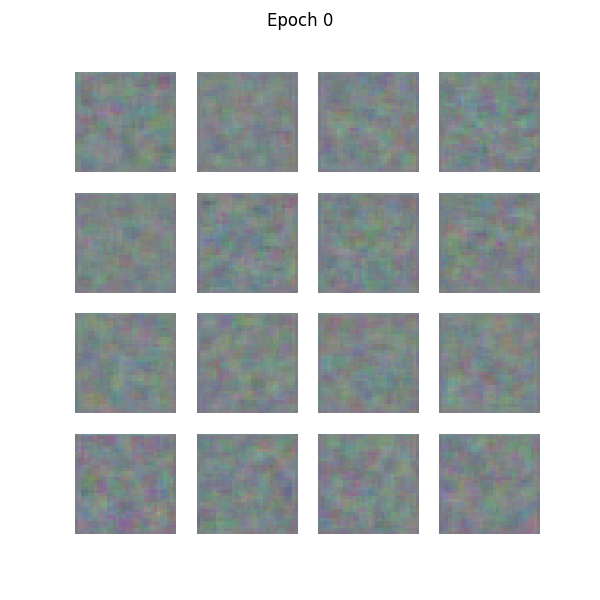

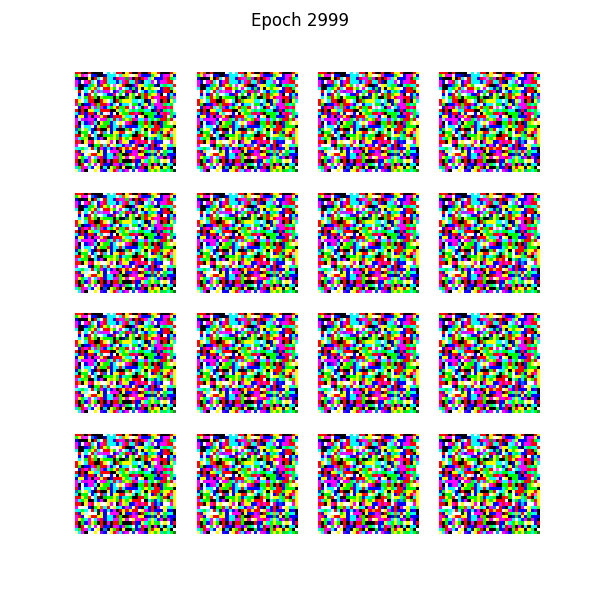

In [1]:
# 🔧 Setup and Imports
import os, time, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout,
    BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# Noise/Suppress logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# 1. Load & preprocess CIFAR-10 ships
(X, y), (_, _) = cifar10.load_data()
X = X[y.flatten() == 8].astype('float32')
X = (X / 127.5) - 1.0  # Normalize to [-1,1]

# 2. Model parameters
img_shape = (32, 32, 3)
latent_dim = 100

# 3. Generator
def build_generator():
    model = Sequential([
        Dense(128*8*8, activation='relu', input_dim=latent_dim),
        Reshape((8, 8, 128)),
        UpSampling2D(), Conv2D(128, 3, padding='same'),
        BatchNormalization(momentum=0.8), Activation('relu'),
        UpSampling2D(), Conv2D(64, 3, padding='same'),
        BatchNormalization(momentum=0.8), Activation('relu'),
        Conv2D(3, 3, padding='same'), Activation('tanh')
    ])
    noise = Input(shape=(latent_dim,))
    return Model(noise, model(noise))

# 4. Discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(32, 3, strides=2, padding='same', input_shape=img_shape),
        LeakyReLU(0.2), Dropout(0.25),
        Conv2D(64, 3, strides=2, padding='same'),
        ZeroPadding2D(((0,1),(0,1))),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2), Dropout(0.25),
        Conv2D(128, 3, strides=2, padding='same'),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2), Dropout(0.25),
        Conv2D(256, 3, strides=1, padding='same'),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2), Dropout(0.25),
        Flatten(), Dense(1, activation='sigmoid')
    ])
    img = Input(shape=img_shape)
    return Model(img, model(img))

# 5. Build GAN
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
generator = build_generator()
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# 6. Training parameters
epochs = 3000  # shorter demo
batch_size = 32
save_interval = 500
start = time.time()

os.makedirs('gan_images', exist_ok=True)

# 7. Training loop
for epoch in range(epochs):
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_imgs = X[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_imgs = generator.predict(noise)
    valid = np.ones((batch_size, 1)) * 0.9 + np.random.rand(batch_size,1)*0.1
    fake = np.zeros((batch_size, 1)) + np.random.rand(batch_size,1)*0.1

    d_loss_real = discriminator.train_on_batch(real_imgs, valid)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = combined.train_on_batch(noise, valid)

    if epoch % 100 == 0:
        elapsed = (time.time() - start)/60
        print(f"{elapsed:.1f} mins: [Epoch {epoch}/{epochs}] D_loss={d_loss[0]:.4f}, acc={100*d_loss[1]:.1f}%, G_loss={g_loss:.4f}")

    if epoch % save_interval == 0 or epoch == epochs-1:
        # Save generated sample grid
        r, c = 4,4
        noise = np.random.normal(0,1,(r*c, latent_dim))
        gen_imgs = generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c, figsize=(6,6))
        for i in range(r*c):
            axs.flat[i].imshow(gen_imgs[i])
            axs.flat[i].axis('off')
        plt.suptitle(f"Epoch {epoch}")
        plt.savefig(f"gan_images/epoch_{epoch}.png")
        plt.close()

# 8. At end, show first & last
from IPython.display import Image, display
display(Image('gan_images/epoch_0.png'))
display(Image(f'gan_images/epoch_{epochs-1}.png'))
